<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Statistical Learning and Data Mining (QBUS6810)</h1></center>
<center><h2>Tutorial 7: Naive Bayes and Sentiment Analysis</h2></center>
<br>

Sentiment analysis is the task of classifying text documents according to the attitude of the writer (or speaker in case of transcription). Sentiment analysis has several applications in areas such as marketing, where online comments, reviews, and messages provide a wealth of data about customers that can be leveraged towards improved brand and customer relationship management strategies. 

One way to approach this problem is to use a [bag of words model](https://en.wikipedia.org/wiki/Bag-of-words_model), which represents the document as a numerical vector. Each element of the vector counts the number or times a word appears in the document, or simply if the word appears in the text (leading to a binary vector).  This is of course a substantial simplification as it disregards any linguistic structure. 


<a class="buttom" href=">#Data:-Twitter-Airline-Sentiment">Data: Twitter Airline Sentiment</a> <br>
<a class="buttom" href="#Text-processing">Text processing</a> <br>
<a class="buttom" href="#Exploratory-data-analysis">Exploratory data analysis</a> <br>
<a class="buttom" href="#Classification-with-one-feature">Classification with one feature</a> <br>
<a class="buttom" href="#Naive-Bayes">Naive Bayes</a> <br>
<a class="buttom" href="#Model-evaluation">Model Evaluation</a> <br>

This notebook relies on the following imports and settings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
sns.set_context('notebook') 
sns.set_style('ticks')
%matplotlib inline

In [2]:
import nltk

##Data: Twitter Airline Sentiment

In this tutorial we use the [Twitter Arline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) dataset provided by a company called [Crowdflower](https://www.crowdflower.com/) on the [Kaggle datasets](https://www.kaggle.com/datasets) page. To build this dataset, the data scientists at Crowdflower scraped all tweets addressed at US airlines in the month of February 2015, including metadata about the message. 

Human contributors then categorised each tweet according to 

In [3]:
data=pd.read_csv('Tweets.csv')
data.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


In sentiment analysis, it is common to use hierachical classifiers that first classify a document as expressing a neutral or non-neutral sentiment, and then classify the sentiment in the documents that are predicted to be polar. Therefore, we simplify our analysis to consider only positive and negatives tweets. Furthermore, we only keep the tweets that were classified with full confidence by the contributors. 

In [4]:
data=data[data['airline_sentiment']!='neutral']
data=data[data['airline_sentiment_confidence']==1.0]

In [5]:
len(data)

8897

Here are examples of negative and positive tweets respectively.

In [6]:
data.loc[4126, 'text']

'@united stuck here in IAH waiting on flight 253 to Honolulu for 7 hours due to maintenance issues. Could we have gotten a new plane!?!? Fail'

In [7]:
data.loc[8644, 'text']

'@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!'

##Text processing

Text analysis requires careful processing of the raw text data to convert documents into a format that is amenable to analysis by machine learning algorithms. The four steps that we use here are:

(1) Tokenization: separate the text into words for a bag of words represenation.

(2) Removing punctuation.

(3) Removing stopwords (non-discriminative words such as "the" and "to").

(4) Stemming and lemmatization: converting words to a root form. Say, it may be more useful to consider "democracy", "democracies", "democratic", and "democratization" as the same token.

In [8]:
from nltk.tokenize import word_tokenize

tweet=data.loc[8644, 'text'] 
tokenized = word_tokenize(tweet)


print('Original:')
print(tweet)
print('\nTokenized:')
print(tokenized)

Original:
@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!

Tokenized:
['@', 'JetBlue', 'had', 'a', 'great', 'flight', 'to', 'Orlando', 'from', 'Hartford', 'a', 'few', 'weeks', 'ago', '!', 'Was', 'great', 'to', 'get', 'out', 'on', 'time', 'and', 'arrive', 'early', '!']


In [9]:
tokenized_no_punctuation=[word.lower() for word in tokenized if word.isalpha()]
print(tokenized_no_punctuation)

['jetblue', 'had', 'a', 'great', 'flight', 'to', 'orlando', 'from', 'hartford', 'a', 'few', 'weeks', 'ago', 'was', 'great', 'to', 'get', 'out', 'on', 'time', 'and', 'arrive', 'early']


In [10]:
from nltk.corpus import stopwords
tokenized_no_stopwords=[word for word in tokenized_no_punctuation if word not in stopwords.words('english')]
print(tokenized_no_stopwords)

['jetblue', 'great', 'flight', 'orlando', 'hartford', 'weeks', 'ago', 'great', 'get', 'time', 'arrive', 'early']


There are different methods for stemming and lemmatization immediately available in the NLTK package. We pick one below.

In [11]:
from nltk.stem.porter import PorterStemmer
tokens = [PorterStemmer().stem(word) for word in tokenized_no_stopwords]
print(tokens)

['jetblu', 'great', 'flight', 'orlando', 'hartford', 'week', 'ago', 'great', 'get', 'time', 'arriv', 'earli']


We put all these steps below into a function that we can apply to the tweets to create a data column containing the tokens. 

In [12]:
# this cell may take over a minute to run, be patient
 
def process_text(text):
    tokenized = word_tokenize(text)
    tokenized_no_punctuation=[word.lower() for word in tokenized if word.isalpha()]
    tokenized_no_stopwords=[word for word in tokenized_no_punctuation if word not in stopwords.words('english')]
    tokens = [PorterStemmer().stem(word) for word in tokenized_no_stopwords]
    return tokens

data['tokens']=data['text'].apply(process_text) # applies a function separatenly to each element of a column      

Let's have a look at the results. Clearly, there would still be room for improvement as we discarded the smileys. 

In [13]:
data[['text','tokens']].head(10)

,text,tokens
3,@VirginAmerica it's really aggressive to blast...,"[virginamerica, realli, aggress, blast, obnoxi..."
4,@VirginAmerica and it's a really big bad thing...,"[virginamerica, realli, big, bad, thing]"
5,@VirginAmerica seriously would pay $30 a fligh...,"[virginamerica, serious, would, pay, flight, s..."
9,"@VirginAmerica it was amazing, and arrived an ...","[virginamerica, amaz, arriv, hour, earli, good]"
11,@VirginAmerica I &lt;3 pretty graphics. so muc...,"[virginamerica, lt, pretti, graphic, much, bet..."
12,@VirginAmerica This is such a great deal! Alre...,"[virginamerica, great, deal, alreadi, think, t..."
14,@VirginAmerica Thanks!,"[virginamerica, thank]"
16,@VirginAmerica So excited for my first cross c...,"[virginamerica, excit, first, cross, countri, ..."
17,@VirginAmerica I flew from NYC to SFO last we...,"[virginamerica, flew, nyc, sfo, last, week, co..."
18,I ❤️ flying @VirginAmerica. ☺️👍,"[fli, virginamerica]"


In [14]:
data['positive']=(data['airline_sentiment']=='positive').astype(int)
train = data.sample(frac=0.7, random_state=1)
test = data[data.index.isin(train.index)==False].copy()

##Exploratory data analysis

We start with some exploratory data analysis for the training data. We find that overall 82.6% of the tweets are negative and 17.4% are positive.

In [15]:
train['airline_sentiment'].value_counts()

negative    5145
positive    1083
Name: airline_sentiment, dtype: int64

In [16]:
train['airline_sentiment'].value_counts(normalize=True).round(3)

negative    0.826
positive    0.174
Name: airline_sentiment, dtype: float64

We can use cross tabulation to break down the numbers by airline.

In [17]:
table=pd.crosstab(train['airline_sentiment'],train['airline'])
table

airline,American,Delta,Southwest,US Airways,United,Virgin America
airline_sentiment,,,,,,
negative,1140,503,634,1337,1454,77
positive,163,228,283,110,224,75


American, US Airways, and United in particular had a high proportion of complaints that month.

In [18]:
table = (table/table.sum()).round(3)
table

airline,American,Delta,Southwest,US Airways,United,Virgin America
airline_sentiment,,,,,,
negative,0.875,0.688,0.691,0.924,0.867,0.507
positive,0.125,0.312,0.309,0.076,0.133,0.493


In graphical format: 

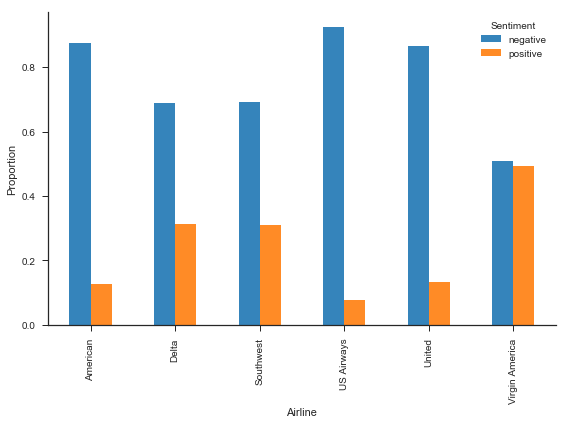

In [19]:
colours=['#1F77B4', '#FF7F0E']

fig, ax = plt.subplots(figsize=(8,6))
(table.T).plot(kind='bar', alpha=0.9, color=colours, ax=ax)
ax.set_xlabel('Airline')
ax.set_ylabel('Proportion')
ax.legend_.set_title('Sentiment')
plt.tight_layout()
sns.despine()
plt.show()

Our main challenge in building the classifier will be to select the features to include in the model. A good way to start is to explore the most common words in each type of document.  We first consider the most common words in the data as a whole. 

In [20]:
fdist = nltk.FreqDist()
for words in train['tokens']:
    for word in words:
            fdist[word] += 1

fdist.most_common()[:20]

[('flight', 2251),
 ('unit', 1833),
 ('usairway', 1520),
 ('americanair', 1400),
 ('southwestair', 935),
 ('jetblu', 823),
 ('get', 736),
 ('thank', 720),
 ('hour', 708),
 ('delay', 597),
 ('servic', 596),
 ('custom', 564),
 ('cancel', 563),
 ('time', 503),
 ('help', 454),
 ('wait', 451),
 ('call', 431),
 ('bag', 425),
 ('hold', 417),
 ('plane', 378)]

With a bit of work, we can turn this into a plot.

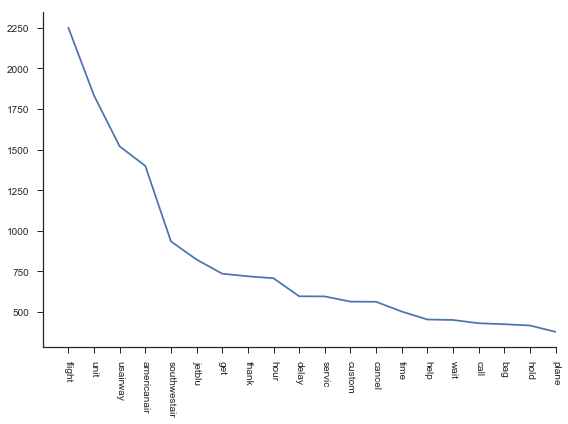

In [21]:
fig, ax = plt.subplots(figsize=(8,6))

y = pd.Series(dict(fdist.most_common()[:20]))
y = y.sort_values(ascending=False)

y.plot()

indexes = np.arange(0, len(y)) # we will place ticks for every word
ax.set_xticks(indexes)
ax.set_xticklabels(y.index, rotation='-90')
ax.set_xlim(-1)

plt.tight_layout()

sns.despine()
plt.show()

Now, let's repeat something similar for positive and negative tweets separately. We introduce some changes by computing the proportion of tweets in which the word appears and then sorting the words accordingly in descending order. 

This analysis gives us important clues for building a classifier. First, nearly half of the positive tweets contain the "thank" word, suggesting that this will be a powerful feature for classification. Not surprisigly, word such as "great", "love", "best", and "awesome" are among the most frequent in the positive tweets, and do not appear among the most frequent negative tweets. In the same way, "delay", "cancel", and "wait" are among the most frequent for negative tweets and are not among the most frequent among positive tweets.

A third group of words such as "flight" and "service" are frequent among both positive and negative tweets and may not be very useful for classification. 

In [22]:
positives=len(train[train['airline_sentiment']=='positive']) # number of positive tweets in the training data

fdist_positive = nltk.FreqDist()
for words in train[train['airline_sentiment']=='positive']['tokens']:
    for word in np.unique(words): # not counting repeated words this time
            fdist_positive[word] += 1

            
common_positive = pd.Series(dict(fdist_positive))/positives # there is probably a better way to do this
common_positive = common_positive.sort_values(ascending=False)
common_positive.head(20).round(3)

thank            0.480
southwestair     0.263
jetblu           0.211
unit             0.211
flight           0.167
americanair      0.157
great            0.113
usairway         0.105
love             0.084
servic           0.084
http             0.078
help             0.073
virginamerica    0.069
fli              0.064
best             0.063
custom           0.061
awesom           0.058
guy              0.057
airlin           0.056
much             0.054
dtype: float64

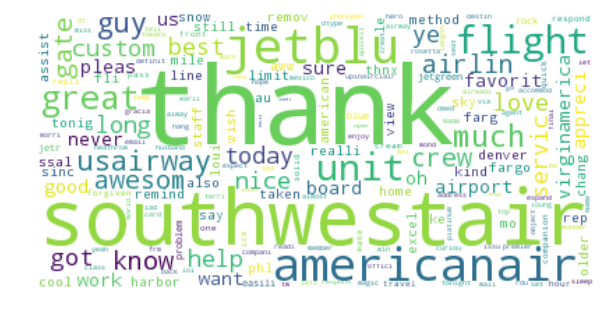

In [33]:
# To run this cell, you would need to install the word cloud package by following the documentation: 
# https://github.com/amueller/word_cloud

positive_tweets = train[train['airline_sentiment']=='positive']['tokens']

from wordcloud import WordCloud

fig, ax = plt.subplots(figsize=(10,8))
wordcloud = WordCloud(background_color="white", max_words=200).generate(str(positive_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
negatives=len(train[train['airline_sentiment']=='negative'])

fdist_negative = nltk.FreqDist()
for words in train[train['airline_sentiment']=='negative']['tokens']:
    for word in np.unique(words): 
            fdist_negative[word] += 1

common_negative = pd.Series(dict(fdist_negative))/negatives
common_negative = common_negative.sort_values(ascending=False)
common_negative.head(20).round(3)

flight          0.313
unit            0.287
usairway        0.266
americanair     0.237
hour            0.128
southwestair    0.126
get             0.123
delay           0.106
cancel          0.102
jetblu          0.100
servic          0.095
custom          0.093
time            0.081
wait            0.079
hold            0.078
bag             0.072
call            0.070
help            0.070
plane           0.064
amp             0.056
dtype: float64

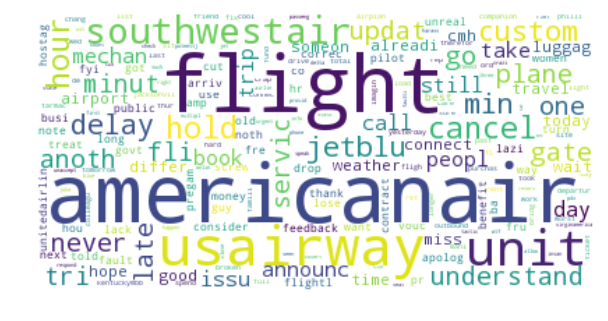

In [34]:
negative_tweets = train[train['airline_sentiment']=='negative']['tokens']

from wordcloud import WordCloud
fig, ax = plt.subplots(figsize=(10,8))
wordcloud = WordCloud(background_color="white", max_words=200).generate(str(negative_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##Classification with one feature

We are ready to build a simple classifier based on one variable. As a baseline, we compute the misclassification rate from always predicting negative.

In [24]:
from sklearn.metrics import accuracy_score
error  = 1 - accuracy_score(np.zeros(len(test)), test['positive'])
print(error.round(3))

0.162


As a learning experience, we first manually implement the classifier.

In [25]:
# a useful future suggested by our analysis above
feature = 'thank'

# Response: simply retrieving the values in the respose value (as a NumPy array, for technical reasons) 
y_train=train['positive'].values

# Feature
# Create a True/False variable that records if the word appears in each tweet
# The lambda defines an anonymous function, which is function that we define in context
X_train=train['tokens'].apply(lambda tokens: (feature in tokens))
X_train.astype(int).values  # Convert to a dummy variable in NumPy array format
           
# Proportion of positives in the training data   
pi=np.mean(y_train) 

# Feature proportion among positives 
theta1=np.sum(X_train*y_train)/np.sum(y_train)

# Feature proportion among negatives 
theta0=np.sum(X_train*(1-y_train))/np.sum(1-y_train)

# Probability of a positive conditional on the feature, using Bayes' theorem
prob = (pi*theta1)/(pi*theta1+(1-pi)*theta0)

We estimate that conditional on the appearance of the token "thank", the document has 74.7% probability of being positive. This is because around 48% of positive tweets have this token, while only 3.4% of negative tweets do.

In [26]:
print(prob.round(3))
print(theta0.round(3))
print(theta1.round(3))

0.747
0.034
0.48


The appearance of "thank" would therefore lead to us to classify a tweet as positive. Let's evaluate the performance of the model for the test data. 

In [27]:
pred = test['tokens'].apply(lambda tokens: (feature in tokens))
error  = 1 - accuracy_score(pred, test['positive'])
print(error.round(3))

0.123


We reduce the misclassification rate from 16.2 to 12.3, a good improvement!

We now switch to the Scikit-Learn implementation of the Naive Bayes method. It is convenient to write a function that creates a design matrix in the format required by Scikit-Learn. 

In [28]:
from sklearn.naive_bayes import BernoulliNB

def design_matrix(feature, series):
    X=series.apply(lambda tokens: (feature in tokens))
    X= X.astype(int) 
    return X.values.reshape((-1,1)) # converting to a NumPy matrix, as required

X_train = design_matrix('thank', train['tokens'])
X_test = design_matrix('thank', test['tokens'])

nbc= BernoulliNB().fit(X_train, np.ravel(y_train))
pred = nbc.predict(X_test)
error  = 1 - accuracy_score(pred, test['positive'])
print(error.round(3))   

0.123


Next, we need a strategy for handling the large number of features. Even though we could implement forward selection, we follow a simpler approach and rank the features according to the performance of univariate models based on each of them.

We can use the code from the EDA part to retrieve a list of features and the corresponding counts.

In [29]:
features = pd.Series(dict(fdist))
features = features.sort_values(ascending=False)
features.head()

flight          2251
unit            1833
usairway        1520
americanair     1400
southwestair     935
dtype: int64

Below are the descriptive statistics for the counts. There are 5439 unique tokens, but more than half appear only once in the training data. 

In [30]:
features.describe().round(0)

count    5439.0
mean       12.0
std        64.0
min         1.0
25%         1.0
50%         1.0
75%         5.0
max      2251.0
dtype: float64

A token with a single training case would cause us to estimate that the associated response class (positive or negative) has probability one conditional on it, which is clearly overfitting. Hence, we set a minimum of ten appearances for us to include the predictor in the analysis, bringing the number of features to 863. 

In [31]:
features = features[features>=10]
len(features)

863

We rank the features according to the training cross-entropy loss, which is based on the estimated conditional probalities rather then the classifications. This makes more sense here as the probabilities are more informative than the classifications (most features do not change the classifications on their own). The cross-entropy loss is the negative log-likelihood of the response data given the estimated probabilities. 

In [32]:
from sklearn.metrics import log_loss

def training_error(feature):
    X_train = design_matrix(feature, train['tokens'])
    nbc= BernoulliNB().fit(X_train, np.ravel(y_train))
    prob = nbc.predict_proba(X_train)
    return log_loss(y_train, prob)

The ranking of the features is as follows.

In [33]:
losses=[]
for feature in features.index:
    losses.append(training_error(feature))

ranked = pd.Series(losses, index=features.index)
ranked = ranked.sort_values()
ranked.head(20)

thank            0.355389
great            0.440795
hour             0.444916
awesom           0.446794
love             0.448045
cancel           0.449977
usairway         0.450178
amaz             0.450254
hold             0.450824
best             0.451438
delay            0.451547
southwestair     0.452590
flight           0.453880
jetblu           0.454560
flightl          0.455096
appreci          0.455097
call             0.455535
virginamerica    0.455734
much             0.456461
hr               0.456552
dtype: float64

##Naive Bayes classification

We first write a function to create the design matrix given a list of features. As a very technical detail, we build it as a sparse matrix for memory efficiency. This is because this binary matrix will get very large below (hundreds of thousands of entries), but vast majority of the elements are zero. 

In [34]:
from scipy.sparse import lil_matrix

def design_matrix(features, series):
    X = lil_matrix((len(series),len(features)))
    for i in range(len(series)):
        tokens = series.iloc[i]
        for j, feature in enumerate(features):
            if feature in tokens:
                X[i, j]= 1.0
    return X

The next cell computes the test error when when use the 10 highest ranked features. We obtain a 9.6% misclassification rate for the test data. 

In [35]:
p = 10

y_test = test['positive'].values
features = list(ranked.index) # storing the list of features in order for later

X_train = design_matrix(features[:p], train['tokens'])
X_test = design_matrix(features[:p], test['tokens'])

nbc= BernoulliNB().fit(X_train, np.ravel(y_train))
y_pred = nbc.predict(X_test)
error  = 1 - accuracy_score(y_test, y_pred)
print(error.round(3)) 

0.096


How many features should we use? As always, we use model selection. Due to the large number of features and observations, cross validation can be slow for this data. We therefore increase the number of predictors by 20 in each step to computational save time. We also compute the test errors for comparison. 

In [36]:
# This cell will take a couple of minutes to run, increase the leap in the loop if needed

from sklearn.model_selection import cross_val_score

test_errors = []
cv_errors = []

n_features = np.arange(0, len(features)+1, 20)
n_features[0] = 1 # the first model has 1 feature, then 20, 40, etc

for p in n_features:
    X_train = design_matrix(features[:p], train['tokens'])
    X_test = design_matrix(features[:p], test['tokens'])
    nbc= BernoulliNB().fit(X_train, np.ravel(y_train))
    
    scores = cross_val_score(nbc, X_train, y_train, cv=10, scoring = 'accuracy')
    cv_errors.append(1-np.mean(scores))
    
    y_pred = nbc.predict(X_test)
    test_errors.append(1 - accuracy_score(y_test, y_pred)) 

The results illustrate our discussion in the lectures: the Naive Bayes method is relatively immune to overfitting. We obtain the best cross validation score with around 400 predictors, but remarkably the performance does not importantly deteriorate if we increase the number of features to include all of them.

The selected model has 93.7% classification accuracy for the test data. 

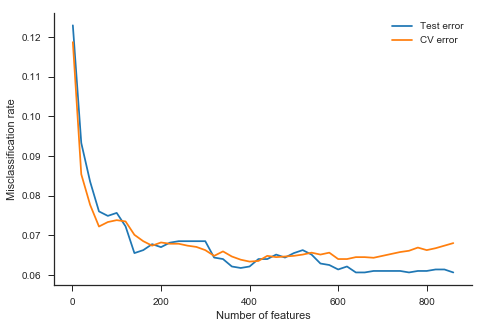

Lowest CV error: K = 400
Lowest test error: K = 640

Test error for the selected model = 0.062


In [37]:
fig, ax= plt.subplots(figsize=(7.5,5))
ax.plot(n_features, test_errors, color='#1F77B4', label='Test error')
ax.plot(n_features, cv_errors, color='#FF7F0E', label='CV error')
ax.set_xlabel('Number of features')
ax.set_ylabel('Misclassification rate')
plt.legend()
sns.despine()
plt.show()

print('Lowest CV error: K = {}'.format(n_features[np.argmin(cv_errors)])) 
print('Lowest test error: K = {}'.format(n_features[np.argmin(test_errors)]))  

print('\nTest error for the selected model = {:.3f}'.format(test_errors[np.argmin(cv_errors)]))  

##Model evaluation

We conclude our analysis by evaluating our selected model. 

In [38]:
p=400
X_train = design_matrix(features[:p], train['tokens'])
X_test = design_matrix(features[:p], test['tokens'])
nbc= BernoulliNB().fit(X_train, np.ravel(y_train))
    
y_pred = nbc.predict(X_test)
prob = nbc.predict_proba(X_test)

The normalised confusion matrix shows that the classifier has 85.4% sensitivity and 95.4% specificity. In less technical terms, it has 85.4% probability of correctly classifying a positive comment and 95.4% probability of correctly classifying a negative comment. 

Normalized confusion matrix


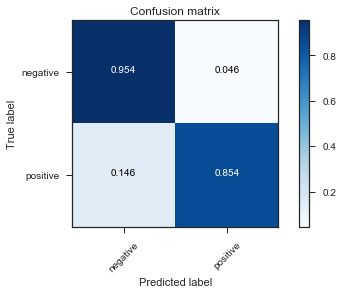

In [43]:
from statlearning import plot_confusion_matrix

# it is important pay attention to the syntax, the true class is the first argument in all these functions
from sklearn.metrics import confusion_matrix
confusion  = confusion_matrix(y_test, y_pred) 

plot_confusion_matrix(confusion, classes=['negative','positive'], normalize=True)
plt.show()

We can compute other individual metrics as follows. 

In [40]:
from sklearn.metrics import recall_score, precision_score,  roc_auc_score

print(recall_score(y_test, y_pred).round(3))
print(precision_score(y_test, y_pred).round(3))

auc = roc_auc_score(y_test, prob[:,1]).round(3)
print(auc)

0.854
0.782
0.969


The ROC curve shows for example that we can a achieve a sensitivity of 93% if we are willing to accept a false positive rate of 10%. However, the false positive rate increases sharply if we try to improve the sensitivity beyond that. 

In [41]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, prob[:,1])

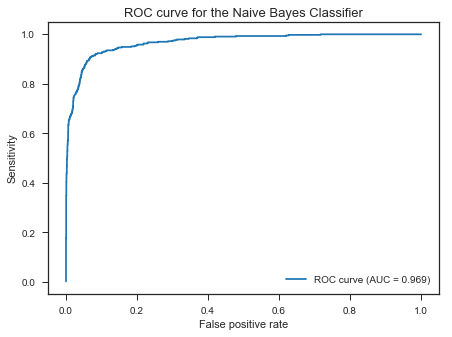

In [42]:
fig, ax= plt.subplots(figsize=(7,5))
ax.plot(fpr, tpr, color='#1F77B4', label='ROC curve (AUC = {:.3f})'.format(auc))
ax.set_xlabel('False positive rate')
ax.set_ylabel('Sensitivity')
ax.set_title('ROC curve for the Naive Bayes Classifier', fontsize=13)
plt.legend()
plt.show()